#  Python modules/packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import pandas as pd

# Required functions

In [21]:
def MC_stock_price_sim(S0,sigma,T,r,K,num_sim,N): ### Monte Carlo simulation for price paths (vectorized form) #
    Z=np.random.standard_normal((num_sim,N))
    dt = T/N
    cumsum_S = np.cumsum((r-0.5*sigma**2)*dt+Z * np.sqrt(dt)*sigma, axis=1) # Vectorized sum
    price_path=S0*np.exp(cumsum_S)
    S0_array=np.zeros((num_sim,1))+S0
    price_path_full=np.concatenate((S0_array,price_path),axis=1) # we want to plot stock price from time zero
    return price_path_full

def MC_option_price(S0,sigma,T,r,K,num_sim): ### Option pricing by Monte Carlo
    z=np.random.standard_normal(num_sim) 
    S_T=S0*np.exp((r-(1/2)*sigma**2)*T+sigma*np.sqrt(T)*z) # simulating stock prices directly at time T
    pay_off=np.maximum(S_T-K,0)    
    V=np.exp(-r*T)*np.mean(pay_off) 
    return V

def MC_option_price_fix_z(S0,sigma,T,r,K,num_sim,z): ### MC price to calculate delta; we used fized z
    S_T=S0*np.exp((r-(1/2)*sigma**2)*T+sigma*np.sqrt(T)*z) 
    pay_off=np.maximum(S_T-K,0)    
    V=np.exp(-r*T)*np.mean(pay_off) 
    return V

def MC_option_delta(S0,sigma,T,r,K,num_sim,z): ### Monte Carlo option delta
    S_T=S0*np.exp((r-(1/2)*sigma**2)*T+sigma*np.sqrt(T)*z)
    S=np.exp((r-(1/2)*sigma**2)*T+sigma*np.sqrt(T)*z)
    indicators= np.where(S_T > K, 1, 0)
    f=indicators*S
    delta=np.exp(-r*T)*np.mean(f)
    return delta
    
def MC_option_gamma(S0,sigma,T,r,K,num_sim,z,del_s):  ### Monte Carlo Option Gamma by central difference method
    forward_term=MC_option_price_fix_z(S0+del_s,sigma,T,r,K,num_sim,z)
    central_term=MC_option_price_fix_z(S0,sigma,T,r,K,num_sim,z)
    backward_term=MC_option_price_fix_z(S0-del_s,sigma,T,r,K,num_sim,z)
    gamma=(forward_term-2*central_term+backward_term)/del_s**2
    return gamma

def MC_option_vega(S0,sigma,T,r,K,num_sim,z): ### Monte Carlo option vega required for implied volatility estimation
    S_T=S0*np.exp((r-(1/2)*sigma**2)*T+sigma*np.sqrt(T)*z)
    S=S0*np.exp((r-(1/2)*sigma**2)*T+sigma*np.sqrt(T)*z)*(-sigma*T+np.sqrt(T)*z) 
    indicator = np.where(S_T > K, 1, 0)
    f=indicator*S   
    vega=np.exp(-r*T)*np.mean(f) 
    return vega

def MC_implied_vol(S0,sigma,T,r,K,num_sim,z,V,tol): ### Implied volatility estimation by Newton Raphson method
    sigma_old=sigma
    max_ite=500
    for i in range(max_ite):       
        f=MC_option_price_fix_z(S0,sigma_old,T,r,K,num_sim,z)-V
        der_f= MC_option_vega(S0,sigma_old,T,r,K,num_sim,z)
        sigma_new=sigma_old-f/der_f
        updated_MC_price=MC_option_price_fix_z(S0,sigma_new,T,r,K,num_sim,z)
        if(np.abs(sigma_old-sigma_new)<tol or np.abs(V-updated_MC_price)<tol):
            break
        sigma_old=sigma_new
    implied_volatility=sigma_new
    return i, implied_volatility

def BS_option_price(S0,sigma,T,r,K): ### Closed form solution of option price from Black Scholes model
    d1=(np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    V=S0*stats.norm.cdf(d1)-K*np.exp(-r*T)*stats.norm.cdf(d2)
    return V

def BS_option_delta(S0,sigma,T,r,K): ### Black scholes option delta
    d1=(np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    delta=stats.norm.cdf(d1)
    return delta

def BS_option_gamma(S0,sigma,T,r,K):  ### Black scholes option Gamma
    d1=(np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    gamma=stats.norm.pdf(d1)/(sigma*S0*np.sqrt(T))
    return gamma

def BS_option_vega(S0,sigma,T,r,K):     ### Black scholes option delta for required for implied volatility estimation
    d1=(np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    vega=S0*stats.norm.pdf(d1)*np.sqrt(T)
    return vega

def BS_implied_vol(S0,sigma,T,r,K,V,tol):  ### Implied volatility estimation by Newton Raphson method
    sigma_old=sigma
    max_ite=500
    for i in range(max_ite):       
        f=BS_option_price(S0,sigma_old,T,r,K)-V
        der_f=BS_option_vega(S0,sigma_old,T,r,K)
        sigma_new=sigma_old-f/der_f
        updated_BS_price=BS_option_price(S0,sigma_new,T,r,K)
        if(np.abs(sigma_old-sigma_new)<tol or np.abs(V-updated_BS_price)<tol):
            break
        sigma_old=sigma_new
    implied_volatility=sigma_new
    return i, implied_volatility

#  Stock price simulation by Monte Carlo (MC) Method

We assume that the stock price follow a Geometric Brownian Motion,  $S_T=S_0 e^{(r -\frac{1}{2}\sigma^2)T+\sigma W_T}$\
where, $S_0$ is the initial stock price, $r$ is the risk free interest rate, $\sigma$ is the marketvolatility, $T$ is time to maturity and $W_t$ is the standard Brownian motion.\
The parameter values considered are: $S_0=49, \sigma=0.25, T=1, r=0$

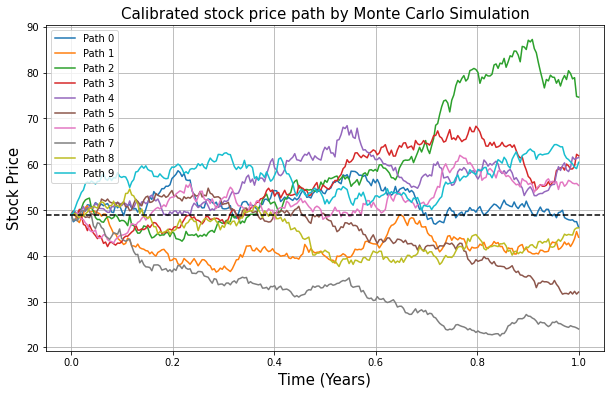

In [11]:
S0,sigma,T,r,K,num_sim=49,0.25,1,0.0,50,10
N=252 #time step
t=np.linspace(0,T,N+1)
sim_price_path=MC_stock_price_sim(S0,sigma,T,r,K,num_sim,N)
#name='C:/Users/shiri/OneDrive/Desktop/Wells_Fargo_Case_study/Figures/stock_price_sim.eps'
plt.figure(figsize=(10, 6))
for i in range(num_sim):
    plt.plot(t, sim_price_path[i], label=f'Path {i}')
plt.axhline(S0, color='black', linestyle='--')
plt.xlabel('Time (Years)',fontsize=15)
plt.ylabel('Stock Price',fontsize=15)
plt.title('Calibrated stock price path by Monte Carlo Simulation',fontsize=15)
plt.legend()
plt.grid(True)
#plt.savefig(name,format='eps')   
plt.show()

# price_path_df = pd.DataFrame(sim_price_path, columns=['Time'] + [f'Path {i}' for i in range(N)])
# price_path_df.to_csv('price_paths.csv', index=False)  

# Histogram and QQ plot to visualize data to ensure that the daily log returns follow a normal distribution.

True Mean=-0.03125 
Sample Mean=-0.03374 
True Variance=0.06250 
Sample Variance=0.06118


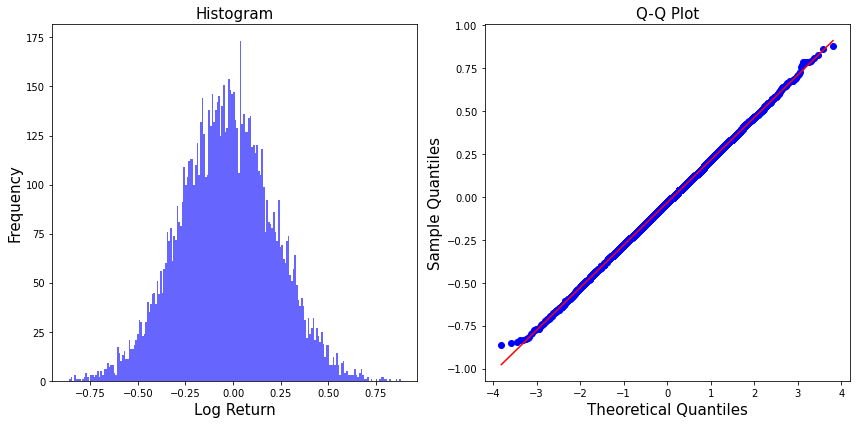

In [497]:
S0,sigma,T,r,K,num_sim=49,0.25,1,0.0,50,10000
N=252 #time step
sim_price_path=MC_stock_price_sim(S0,sigma,T,r,K,num_sim,N)

### Calculating the mean variance of log(S_T/S0) and comparing with the true mean and variance #####

S_T=sim_price_path[:,-1]
log_return=np.log(S_T/S0)
true_mean=-(1/2)*sigma**2*T
true_variance=sigma**2*T
sample_mean=np.mean(log_return)
sample_variance=np.var(log_return)
print('True Mean=%0.5f' % true_mean,
     '\nSample Mean=%0.5f'% sample_mean,
     '\nTrue Variance=%0.5f'% true_variance,
     '\nSample Variance=%0.5f'% sample_variance)

#Creating a histrogram
#name='C:/Users/shiri/OneDrive/Desktop/Wells_Fargo_Case_study/Figures/hist_qq.eps'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram
ax1.hist(log_return, bins=200, density=False, alpha=0.6, color='b')
ax1.set_xlabel('Log Return',fontsize=15)
ax1.set_ylabel('Frequency',fontsize=15)
ax1.set_title('Histogram',fontsize=15)

# Create a Q-Q plot
stats.probplot(log_return, dist="norm", plot=ax2)
ax2.set_xlabel('Theoretical Quantiles',fontsize=15)
ax2.set_ylabel('Sample Quantiles',fontsize=15)
ax2.set_title('Q-Q Plot',fontsize=15)
plt.tight_layout()
#plt.savefig(name,format='eps')
plt.show()

# Monte Carlo and Black scholes Option Pricing Comparison

The price of an European call option, $P=e^{-rT}E_r\big[max(S_T-K,0)\big]$\
where, 
$max(S_T-K,0)$ = \begin{cases}S_T - K, & \text{if } S_T > K \\
    0, & \text{otherwise}
\end{cases}

Monte carlo formula for European Call option price, $P_M=\frac{1}{N}\sum_{i=1}^{N}max(S_T^i-K,0)$,
where, $N$ is the number of samples.

The Black Scholes formula for European Call option price, $P_B=N(d_1)S_0-N(d_2)Ke^{-rT}$, \
where $K$ is the strike price, $N(.)$ is the standard normal cumulative density function and $d_1$ and $d_2$ is defined by\
$d_1=\frac{\ln\big(\frac{S_0}{K}\big)+\big(r+\frac{\sigma^2}{2}\big)T}{\sigma \sqrt T}$,\
$d_2=d_1-\sigma\sqrt T$

In [12]:
S0,sigma,T,r,K,num_sim=49,0.25,1,0.0,50,10**8
start=time.time()  # We want to count the time for Monte Carlo Estimation
Monte_Carlo_Price=MC_option_price(S0,sigma,T,r,K,num_sim)
end=time.time()
time_elapsed=end-start
print('Time elapse for Monte Carlo Estimation = %0.5f' % time_elapsed,'sec')
Black_Scholes_Price=BS_option_price(S0,sigma,T,r,K)
Percent_error=100*np.abs(Black_Scholes_Price-Monte_Carlo_Price)/Black_Scholes_Price
print('Monte_Carlo_Price = %0.5f' % Monte_Carlo_Price,
      '\nBlack_Scholes_Price = %0.5f' % Black_Scholes_Price,
     '\nPricing Error in percent = %0.5f' % Percent_error,'%')

Time elapse for Monte Carlo Estimation = 4.10601 sec
Monte_Carlo_Price = 4.44079 
Black_Scholes_Price = 4.44007 
Pricing Error in percent = 0.01614 %


#  Box plot to analyze the Monte Carlo estimation performance

In [15]:
x={}
num_sim_list=[10**6,10**7,10**8]
M=50 # Number of estimates

for i in num_sim_list:
    start=time.time()
    price=[]
    for j in range(M):
        price.append(MC_option_price(S0,sigma,T,r,K,i))
    x[i]=price
    end=time.time()
    time_elapsed=end-start
    mean_est=sum(x[i])/len(x[i])
    print('No of simulation = %d' %i,'Mean of Estimates = %0.5f' % mean_est,  #True soln  4.44007 
          'Time elapsed = %0.5f' % time_elapsed,'sec')

No of simulation = 1000000 Mean of Estimates = 4.44190 Time elapsed = 1.84609 sec
No of simulation = 10000000 Mean of Estimates = 4.43985 Time elapsed = 18.57743 sec
No of simulation = 100000000 Mean of Estimates = 4.43997 Time elapsed = 199.96245 sec


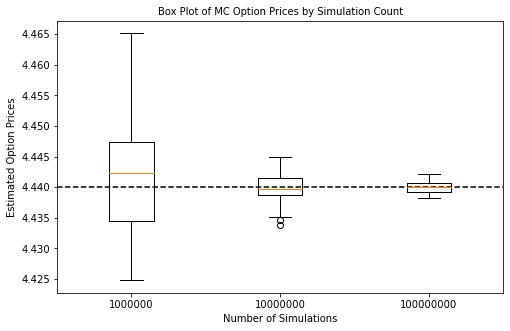

In [16]:
data = [x[key] for key in x.keys()]
#name='C:/Users/shiri/OneDrive/Desktop/Wells_Fargo_Case_study/Figures/box_plot.eps'
plt.figure(figsize=(8, 5))
# Create a box plot
plt.boxplot(data)

plt.xticks(range(1, len(x) + 1), x.keys())
plt.axhline(4.44007, color='black', linestyle='--')
plt.xlabel('Number of Simulations',fontsize=10)
plt.ylabel('Estimated Option Prices',fontsize=10)
plt.title('Box Plot of MC Option Prices by Simulation Count',fontsize=10)
#plt.savefig(name,format='eps')
plt.show()


# Estimating Delta and Gamma by Monte Carlo (MC) method. For the Monte Carlo estimation, the randomness of the Brownian motion has been kept fixed.

Delta is the option sensitivity with respective to the stock price. Mathematicaly, it is written as the first order derivative of the option price with respect to the stock price.\
Monte Carlo delta, $\delta_M=\frac{\partial P}{\partial S_0}= \sum_{i=1}^{N}e^{-\frac{1}{2}\sigma^2 T+\sigma \sqrt T Z^i }$, where $Z^i$ are the i.i.d standard normal. \
Black Scholes delta, $\delta_B =N(d_1)$

In [19]:
z=np.random.standard_normal(num_sim) # fixed standard normal random number for the central difference
S0,sigma,T,r,K,num_sim=49,0.25,1,0.0,50,10**8
delta_MC=MC_option_delta(S0,sigma,T,r,K,num_sim,z)
delta_BS=BS_option_delta(S0,sigma,T,r,K)
print('Monte Carlo Option Delta = %0.5f' % delta_MC,
     '\nBlack Scholes Option Delta = %0.5f' % delta_BS)

Monte Carlo Option Delta = 0.51766 
Black Scholes Option Delta = 0.51762


Gamma is teh second order partial derivative of the option price with respect to the stock price.
Monte Carlo Gamma, $\gamma_M =\frac{\partial^2P}{\partial S_0^2}=\frac{V(S_0+\Delta S)-2V(S_0)+V(S_0-\Delta S)}{\Delta S^2}$\
Black Scholes Gamma, $\gamma_B=\frac{N'(d_1)}{\sigma S_0 \sqrt T}$

In [20]:
del_s=[0.5,1.0,2.0]
gamma_BS=BS_option_gamma(S0,sigma,T,r,K) # Gamma from the black scholes model
for i in del_s:
    gamma_MC=MC_option_gamma(S0,sigma,T,r,K,num_sim,z,i)
    print('Change in Price (Del_s) = %0.1f' % i,'Monte Carlo Option gamma = %0.5f' % gamma_MC,
          'Black scholes Option Gamma = %0.5f' % gamma_BS)

Change in Price (Del_s) = 0.5 Monte Carlo Option gamma = 0.03255 Black scholes Option Gamma = 0.03253
Change in Price (Del_s) = 1.0 Monte Carlo Option gamma = 0.03254 Black scholes Option Gamma = 0.03253
Change in Price (Del_s) = 2.0 Monte Carlo Option gamma = 0.03249 Black scholes Option Gamma = 0.03253


# Implied Volatility by MC and Black scholes model

Implied volatility represents the volatility of the option that aligns the estimated model price with the market price. In order to estimate the implied volatility, We need to find the root of the non-linear equation $P(\sigma)-\bar P=0$.
where, $\bar P$ is the option market price and $P(\sigma)$ is the model price.

To find the root the most common choice is the Newton Raphson method as follows:\
$\sigma_{k+1}=\sigma_k -\frac{P(\sigma)}{P'(\sigma)}$


In [501]:
market_price=6.0
tolerance=10**-8
sigma_initial=0.1
num_sim=10**8
z=np.random.standard_normal(num_sim)
ite_MC,implied_vol_MC=MC_implied_vol(S0,sigma_initial,T,r,K,num_sim,z,market_price,tolerance)
ite_BS,implied_vol_BS=BS_implied_vol(S0,sigma_initial,T,r,K,market_price,tolerance)
print('Implide volatility by Monte Carlo = %.5f' % implied_vol_MC,'Iteration required = ',ite_MC,
     '\nImplied volatility by Black scholes = %0.5f' % implied_vol_BS,'Iteration required = ',ite_BS)

Implide volatility by Monte Carlo = 0.33001 Iteration required =  2 
Implied volatility by Black scholes = 0.33004 Iteration required =  2
